In [12]:
# Import pyomo libraries
import pandas as pd
import pyomo.environ as pe
import pyomo.gdp as pyogdp
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from itertools import product

In [13]:
# Define Model
model = pe.ConcreteModel()

In [14]:
class TheatreScheduler:

    def __init__(self, case_file_path, session_file_path):
        """
        Read case and session data into Pandas DataFrames
        Args:
            case_file_path (str): path to case data in CSV format
            session_file_path (str): path to theatre session data in CSV format
        """
        try:
            self.df_cases = pd.read_csv(case_file_path)
        except FileNotFoundError:
            print("Case data not found.")

        try:
            self.df_sessions = pd.read_csv(session_file_path)
        except FileNotFoundError:
            print("Session data not found")
            
        self.model = self.create_model()
    
    def _generate_case_durations(self):
        """
        Generate mapping of cases IDs to median case time for the procedure
        Returns:
            (dict): dictionary with CaseID as key and median case time (mins) for procedure as value
        """
        #return pd.Series(self.df_cases["Median Duration"].values, index=self.df_cases["CaseID"]).to_dict()
        return pd.Series(self.df_cases["Expected Duration"].values, index=self.df_cases["CaseID"]).to_dict()

    def _generate_session_durations(self):
        """
        Generate mapping of all theatre sessions IDs to session duration in minutes
        Returns:
            (dict): dictionary with SessionID as key and session duration as value
        """
        return pd.Series(self.df_sessions["Duration"].values, index=self.df_sessions["SessionID"]).to_dict()

    def _generate_session_start_times(self):
        """
        Generate mapping from SessionID to session start time
        Returns:
            (dict): dictionary with SessionID as key and start time in minutes since midnight as value
        """
        # Convert session start time from HH:MM:SS format into seconds elapsed since midnight
        self.df_sessions.loc[:, "Start"] = pd.to_timedelta(self.df_sessions["Start"])
        self.df_sessions.loc[:, "Start"] = self.df_sessions["Start"].dt.total_seconds() / 60
        return pd.Series(self.df_sessions["Start"].values, index=self.df_sessions["SessionID"]).to_dict()

    def _get_ordinal_case_deadlines(self):
        """
        #TODO
        Returns:

        """
        self.df_cases.loc[:, "TargetDeadline"] = pd.to_datetime(self.df_cases["TargetDeadline"], format="%d/%m/%Y")
        self.df_cases.loc[:, "TargetDeadline"] = self.df_cases["TargetDeadline"].apply(lambda date: date.toordinal())
        return pd.Series(self.df_cases["TargetDeadline"].values, index=self.df_cases["CaseID"]).to_dict()

    def _get_ordinal_session_dates(self):
        """
        #TODO
        Returns:

        """
        self.df_sessions.loc[:, "Date"] = pd.to_datetime(self.df_sessions["Date"], format="%d/%m/%Y")
        self.df_sessions.loc[:, "Date"] = self.df_sessions["Date"].apply(lambda date: date.toordinal())
        return pd.Series(self.df_sessions["Date"].values, index=self.df_sessions["SessionID"]).to_dict()

    def _generate_disjunctions(self):
        """
        #TODO
        Returns:
            disjunctions (list): list of tuples containing disjunctions
        """
        cases = self.df_cases["CaseID"].to_list()
        sessions = self.df_sessions["SessionID"].to_list()
        disjunctions = []
        for (case1, case2, session) in product(cases, cases, sessions):
            if (case1 != case2) and (case2, case1, session) not in disjunctions:
                disjunctions.append((case1, case2, session))

        return disjunctions
    
    def create_model(self):
        model = pe.ConcreteModel()

        # Model Data

        # List of case IDs in surgical waiting list
        model.CASES = pe.Set(initialize=self.df_cases["CaseID"].tolist())
        # List of sessions IDs
        model.SESSIONS = pe.Set(initialize=self.df_sessions["SessionID"].tolist())
        # List of tasks - all possible (caseID, sessionID) combination
        model.TASKS = pe.Set(initialize=model.CASES * model.SESSIONS, dimen=2)
        # The duration (median case time) for each operation
        model.CASE_DURATION = pe.Param(model.CASES, initialize=self._generate_case_durations())
        # The duration of each theatre session
        model.SESSION_DURATION = pe.Param(model.SESSIONS, initialize=self._generate_session_durations())
        # The start time of each theatre session
        model.SESSION_START_TIME = pe.Param(model.SESSIONS, initialize=self._generate_session_start_times())
        # The deadline of each case
        model.CASE_DEADLINES = pe.Param(model.CASES, initialize=self._get_ordinal_case_deadlines())
        # The date of each theatre session
        model.SESSION_DATES = pe.Param(model.SESSIONS, initialize=self._get_ordinal_session_dates())


        model.DISJUNCTIONS = pe.Set(initialize=self._generate_disjunctions(), dimen=3)

        ub = 1440  # seconds in a day
        model.M = pe.Param(initialize=1e3*ub)  # big M
        max_util = 0.85
        num_cases = self.df_cases.shape[0]

        # Decision Variables
        model.SESSION_ASSIGNED = pe.Var(model.TASKS, domain=pe.Binary)
        model.CASE_START_TIME = pe.Var(model.TASKS, bounds=(0, ub), within=pe.PositiveReals)
        model.CASES_IN_SESSION = pe.Var(model.SESSIONS, bounds=(0, num_cases), within=pe.PositiveReals)

        # Objective
        def objective_function(model):
            return pe.summation(model.CASES_IN_SESSION)
            #return sum([model.SESSION_ASSIGNED[case, session] for case in model.CASES for session in model.SESSIONS])
        model.OBJECTIVE = pe.Objective(rule=objective_function, sense=pe.maximize)

        # Constraints

        # Case start time must be after start time of assigned theatre session
        def case_start_time(model, case, session):
            return model.CASE_START_TIME[case, session] >= model.SESSION_START_TIME[session] - \
                   ((1 - model.SESSION_ASSIGNED[(case, session)])*model.M)
        model.CASE_START = pe.Constraint(model.TASKS, rule=case_start_time)

        # Case end time must be before end time of assigned theatre session
        def case_end_time(model, case, session):
            return model.CASE_START_TIME[case, session] + model.CASE_DURATION[case] <= model.SESSION_START_TIME[session] + \
                   model.SESSION_DURATION[session]*max_util + ((1 - model.SESSION_ASSIGNED[(case, session)]) * model.M)
        model.CASE_END_TIME = pe.Constraint(model.TASKS, rule=case_end_time)

        # Cases can be assigned to a maximum of one session
        def session_assignment(model, case):
            return sum([model.SESSION_ASSIGNED[(case, session)] for session in model.SESSIONS]) <= 1
        model.SESSION_ASSIGNMENT = pe.Constraint(model.CASES, rule=session_assignment)

        def set_deadline_condition(model, case, session):
            return model.SESSION_DATES[session] <= model.CASE_DEADLINES[case] + ((1 - model.SESSION_ASSIGNED[case, session])*model.M)
        model.APPLY_DEADLINE = pe.Constraint(model.TASKS, rule=set_deadline_condition)

        def no_case_overlap(model, case1, case2, session):
            return [model.CASE_START_TIME[case1, session] + model.CASE_DURATION[case1] <= model.CASE_START_TIME[case2, session] + \
                    ((2 - model.SESSION_ASSIGNED[case1, session] - model.SESSION_ASSIGNED[case2, session])*model.M),
                    model.CASE_START_TIME[case2, session] + model.CASE_DURATION[case2] <= model.CASE_START_TIME[case1, session] + \
                    ((2 - model.SESSION_ASSIGNED[case1, session] - model.SESSION_ASSIGNED[case2, session])*model.M)]

        model.DISJUNCTIONS_RULE = pyogdp.Disjunction(model.DISJUNCTIONS, rule=no_case_overlap)

        def theatre_util(model, session):
            return model.CASES_IN_SESSION[session] == \
                   sum([model.SESSION_ASSIGNED[case, session] for case in model.CASES])

        model.THEATRE_UTIL = pe.Constraint(model.SESSIONS, rule=theatre_util)

        pe.TransformationFactory("gdp.bigm").apply_to(model)

        return model
    
    def solve(self, solver_name, options=None, solver_path=None, local=True):

        if solver_path is not None:
            solver = pe.SolverFactory(solver_name, executable=solver_path)
        else:
            solver = pe.SolverFactory(solver_name)

        # TODO remove - too similar to alstom
        if options is not None:
            for key, value in options.items():
                solver.options[key] = value

        if local:
            solver_results = solver.solve(self.model, tee=True)
        else:
            solver_manager = pe.SolverManagerFactory("neos")
            solver_results = solver_manager.solve(self.model, opt=solver)

        results = [{"Case": case,
                    "Session": session,
                    "Session Date": self.model.SESSION_DATES[session],
                    "Case Deadline": self.model.CASE_DEADLINES[case],
                    "Days before deadline": self.model.CASE_DEADLINES[case] - self.model.SESSION_DATES[session],
                    "Start": self.model.CASE_START_TIME[case, session](),
                    "Assignment": self.model.SESSION_ASSIGNED[case, session]()}
                   for (case, session) in self.model.TASKS]

        self.df_times = pd.DataFrame(results)

        all_cases = self.model.CASES.value_list
        cases_assigned = []
        for (case, session) in self.model.SESSION_ASSIGNED:
            if self.model.SESSION_ASSIGNED[case, session] == 1:
                cases_assigned.append(case)

        cases_missed = list(set(all_cases).difference(cases_assigned))
        print("Number of cases assigned = {} out of {}:".format(len(cases_assigned), len(all_cases)))
        print("Cases assigned: ", cases_assigned)
        print("Number of cases missed = {} out of {}:".format(len(cases_missed), len(all_cases)))
        print("Cases missed: ", cases_missed)
        self.model.CASES_IN_SESSION.pprint()
        print("Total Objective = {}".format(sum(self.model.CASES_IN_SESSION.get_values().values())))
        print("Number of constraints = {}".format(solver_results["Problem"].__getitem__(0)["Number of constraints"]))
        #self.model.SESSION_ASSIGNED.pprint()
        print(self.df_times[self.df_times["Assignment"] == 1].to_string())
        self.draw_gantt()

    def draw_gantt(self):

        df = self.df_times[self.df_times["Assignment"] == 1]
        cases = sorted(list(df['Case'].unique()))
        sessions = sorted(list(df['Session'].unique()))

        bar_style = {'alpha': 1.0, 'lw': 25, 'solid_capstyle': 'butt'}
        text_style = {'color': 'white', 'weight': 'bold', 'ha': 'center', 'va': 'center'}
        colors = cm.Dark2.colors

        df.sort_values(by=['Case', 'Session'])
        df.set_index(['Case', 'Session'], inplace=True)

        fig, ax = plt.subplots(1, 1)
        for c_ix, c in enumerate(cases, 1):
            for s_ix, s in enumerate(sessions, 1):
                if (c, s) in df.index:
                    xs = df.loc[(c, s), 'Start']
                    xf = df.loc[(c, s), 'Start'] + \
                         self.df_cases[self.df_cases["CaseID"] == c]["Expected Duration"]
                    ax.plot([xs, xf], [s] * 2, c=colors[c_ix % 7], **bar_style)
                    ax.text((xs + xf) / 2, s, c, **text_style)

        ax.set_title('Assigning Ophthalmology Cases to Theatre Sessions')
        ax.set_xlabel('Time')
        ax.set_ylabel('Sessions')
        ax.grid(True)

        fig.tight_layout()
        plt.show()

In [15]:
# Import cases and sessions data into pyomo model
case_path = os.path.join(os.path.dirname(os.getcwd()), "data", "cases.csv")
session_path = os.path.join(os.path.dirname(os.getcwd()), "data", "sessions.csv")
options = {"seconds": 300}
scheduler = TheatreScheduler(case_file_path=case_path, session_file_path=session_path)

Welcome to the CBC MILP Solver 
Version: 2.10.8 
Build Date: May  5 2022 

command line - C:\Program Files\Cbc-releases.2.10.8-w64-msvc16-md\bin\cbc.exe -seconds 300 -printingOptions all -import C:\Users\liuda\AppData\Local\Temp\tmp3_2jw65_.pyomo.lp -stat=1 -solve -solu C:\Users\liuda\AppData\Local\Temp\tmp3_2jw65_.pyomo.soln (default strategy 1)
seconds was changed from 1e+100 to 300
Option for printingOptions changed from normal to all
 CoinLpIO::readLp(): Maximization problem reformulated as minimization
Coin0009I Switching back to maximization to get correct duals etc
Presolve is modifying 8 integer bounds and re-presolving
Presolve 2972 (-2643) rows, 1578 (-2147) columns and 14188 (-7537) elements
Statistics for presolved model
Original problem has 3592 integers (3592 of which binary)
Presolved problem has 1472 integers (1472 of which binary)
==== 1472 zero objective 2 different
1472 variables have objective of -0
106 variables have objective of 1
==== absolute objective values 2 

Cbc0010I After 2700 nodes, 1218 on tree, -27 best solution, best possible -30 (6.18 seconds)
Cbc0010I After 2800 nodes, 1265 on tree, -27 best solution, best possible -30 (6.40 seconds)
Cbc0010I After 2900 nodes, 1322 on tree, -27 best solution, best possible -30 (6.57 seconds)
Cbc0038I Full problem 2972 rows 1578 columns, reduced to 195 rows 62 columns
Cbc0010I After 3000 nodes, 1368 on tree, -27 best solution, best possible -30 (6.76 seconds)
Cbc0010I After 3100 nodes, 1414 on tree, -27 best solution, best possible -30 (6.91 seconds)
Cbc0010I After 3200 nodes, 1465 on tree, -27 best solution, best possible -30 (7.03 seconds)
Cbc0010I After 3300 nodes, 1497 on tree, -27 best solution, best possible -30 (7.18 seconds)
Cbc0010I After 3400 nodes, 1524 on tree, -27 best solution, best possible -30 (7.33 seconds)
Cbc0010I After 3500 nodes, 1573 on tree, -27 best solution, best possible -30 (7.50 seconds)
Cbc0038I Full problem 2972 rows 1578 columns, reduced to 199 rows 66 columns
Cbc0010I 

Cbc0010I After 14900 nodes, 4016 on tree, -28 best solution, best possible -30 (31.23 seconds)
Cbc0010I After 15000 nodes, 4055 on tree, -28 best solution, best possible -30 (31.36 seconds)
Cbc0010I After 15100 nodes, 4104 on tree, -28 best solution, best possible -30 (31.48 seconds)
Cbc0010I After 15200 nodes, 4157 on tree, -28 best solution, best possible -30 (31.62 seconds)
Cbc0010I After 15300 nodes, 4210 on tree, -28 best solution, best possible -30 (31.77 seconds)
Cbc0010I After 15400 nodes, 4264 on tree, -28 best solution, best possible -30 (31.94 seconds)
Cbc0010I After 15500 nodes, 4322 on tree, -28 best solution, best possible -30 (32.10 seconds)
Cbc0010I After 15600 nodes, 4379 on tree, -28 best solution, best possible -30 (32.27 seconds)
Cbc0010I After 15700 nodes, 4431 on tree, -28 best solution, best possible -30 (32.42 seconds)
Cbc0010I After 15800 nodes, 4483 on tree, -28 best solution, best possible -30 (32.56 seconds)
Cbc0010I After 15900 nodes, 4537 on tree, -28 best

Cbc0010I After 23500 nodes, 6075 on tree, -28 best solution, best possible -30 (54.20 seconds)
Cbc0010I After 23600 nodes, 6078 on tree, -28 best solution, best possible -30 (54.64 seconds)
Cbc0010I After 23700 nodes, 6083 on tree, -28 best solution, best possible -30 (55.00 seconds)
Cbc0010I After 23800 nodes, 6127 on tree, -28 best solution, best possible -30 (55.18 seconds)
Cbc0010I After 23900 nodes, 6187 on tree, -28 best solution, best possible -30 (55.33 seconds)
Cbc0010I After 24000 nodes, 6209 on tree, -28 best solution, best possible -30 (55.78 seconds)
Cbc0010I After 24100 nodes, 6208 on tree, -28 best solution, best possible -30 (56.27 seconds)
Cbc0010I After 24200 nodes, 6204 on tree, -28 best solution, best possible -30 (56.84 seconds)
Cbc0010I After 24300 nodes, 6204 on tree, -28 best solution, best possible -30 (57.31 seconds)
Cbc0010I After 24400 nodes, 6238 on tree, -28 best solution, best possible -30 (57.53 seconds)
Cbc0010I After 24500 nodes, 6278 on tree, -28 best

Cbc0010I After 36200 nodes, 8322 on tree, -28 best solution, best possible -30 (90.74 seconds)
Cbc0010I After 36300 nodes, 8377 on tree, -28 best solution, best possible -30 (90.93 seconds)
Cbc0010I After 36400 nodes, 8434 on tree, -28 best solution, best possible -30 (91.11 seconds)
Cbc0010I After 36500 nodes, 8478 on tree, -28 best solution, best possible -30 (91.32 seconds)
Cbc0010I After 36600 nodes, 8532 on tree, -28 best solution, best possible -30 (91.47 seconds)
Cbc0010I After 36700 nodes, 8582 on tree, -28 best solution, best possible -30 (91.64 seconds)
Cbc0010I After 36800 nodes, 8632 on tree, -28 best solution, best possible -30 (91.77 seconds)
Cbc0010I After 36900 nodes, 8682 on tree, -28 best solution, best possible -30 (91.90 seconds)
Cbc0010I After 37000 nodes, 8729 on tree, -28 best solution, best possible -30 (92.07 seconds)
Cbc0010I After 37100 nodes, 8727 on tree, -28 best solution, best possible -30 (92.26 seconds)
Cbc0010I After 37200 nodes, 8729 on tree, -28 best

Cbc0010I After 44600 nodes, 11845 on tree, -28 best solution, best possible -30 (109.74 seconds)
Cbc0010I After 44700 nodes, 11840 on tree, -28 best solution, best possible -30 (109.99 seconds)
Cbc0010I After 44800 nodes, 11836 on tree, -28 best solution, best possible -30 (110.22 seconds)
Cbc0010I After 44900 nodes, 11832 on tree, -28 best solution, best possible -30 (110.46 seconds)
Cbc0010I After 45000 nodes, 11866 on tree, -28 best solution, best possible -30 (110.67 seconds)
Cbc0010I After 45100 nodes, 11884 on tree, -28 best solution, best possible -30 (110.87 seconds)
Cbc0010I After 45200 nodes, 11891 on tree, -28 best solution, best possible -30 (111.08 seconds)
Cbc0010I After 45300 nodes, 11892 on tree, -28 best solution, best possible -30 (111.22 seconds)
Cbc0010I After 45400 nodes, 11883 on tree, -28 best solution, best possible -30 (111.44 seconds)
Cbc0010I After 45500 nodes, 11891 on tree, -28 best solution, best possible -30 (111.58 seconds)
Cbc0010I After 45600 nodes, 11

Cbc0010I After 57100 nodes, 13712 on tree, -28 best solution, best possible -30 (139.18 seconds)
Cbc0010I After 57200 nodes, 13706 on tree, -28 best solution, best possible -30 (139.34 seconds)
Cbc0010I After 57300 nodes, 13696 on tree, -28 best solution, best possible -30 (139.53 seconds)
Cbc0010I After 57400 nodes, 13683 on tree, -28 best solution, best possible -30 (139.82 seconds)
Cbc0010I After 57500 nodes, 13672 on tree, -28 best solution, best possible -30 (139.97 seconds)
Cbc0010I After 57600 nodes, 13646 on tree, -28 best solution, best possible -30 (140.15 seconds)
Cbc0010I After 57700 nodes, 13645 on tree, -28 best solution, best possible -30 (140.40 seconds)
Cbc0010I After 57800 nodes, 13641 on tree, -28 best solution, best possible -30 (140.62 seconds)
Cbc0010I After 57900 nodes, 13643 on tree, -28 best solution, best possible -30 (140.86 seconds)
Cbc0010I After 58000 nodes, 13640 on tree, -28 best solution, best possible -30 (141.10 seconds)
Cbc0010I After 58100 nodes, 13

Cbc0010I After 69700 nodes, 14563 on tree, -28 best solution, best possible -30 (169.09 seconds)
Cbc0010I After 69800 nodes, 14566 on tree, -28 best solution, best possible -30 (169.31 seconds)
Cbc0010I After 69900 nodes, 14565 on tree, -28 best solution, best possible -30 (169.49 seconds)
Cbc0010I After 70000 nodes, 14564 on tree, -28 best solution, best possible -30 (169.71 seconds)
Cbc0010I After 70100 nodes, 14566 on tree, -28 best solution, best possible -30 (169.96 seconds)
Cbc0010I After 70200 nodes, 14565 on tree, -28 best solution, best possible -30 (170.19 seconds)
Cbc0010I After 70300 nodes, 14571 on tree, -28 best solution, best possible -30 (170.42 seconds)
Cbc0010I After 70400 nodes, 14568 on tree, -28 best solution, best possible -30 (170.64 seconds)
Cbc0010I After 70500 nodes, 14564 on tree, -28 best solution, best possible -30 (170.84 seconds)
Cbc0010I After 70600 nodes, 14559 on tree, -28 best solution, best possible -30 (171.08 seconds)
Cbc0010I After 70700 nodes, 14

Cbc0010I After 82300 nodes, 14507 on tree, -28 best solution, best possible -30 (195.30 seconds)
Cbc0010I After 82400 nodes, 14502 on tree, -28 best solution, best possible -30 (195.51 seconds)
Cbc0010I After 82500 nodes, 14503 on tree, -28 best solution, best possible -30 (195.70 seconds)
Cbc0010I After 82600 nodes, 14503 on tree, -28 best solution, best possible -30 (195.91 seconds)
Cbc0010I After 82700 nodes, 14500 on tree, -28 best solution, best possible -30 (196.09 seconds)
Cbc0010I After 82800 nodes, 14500 on tree, -28 best solution, best possible -30 (196.30 seconds)
Cbc0010I After 82900 nodes, 14504 on tree, -28 best solution, best possible -30 (196.47 seconds)
Cbc0010I After 83000 nodes, 14498 on tree, -28 best solution, best possible -30 (196.61 seconds)
Cbc0010I After 83100 nodes, 14501 on tree, -28 best solution, best possible -30 (196.75 seconds)
Cbc0010I After 83200 nodes, 14496 on tree, -28 best solution, best possible -30 (196.93 seconds)
Cbc0010I After 83300 nodes, 14

Cbc0010I After 90800 nodes, 14499 on tree, -28 best solution, best possible -30 (212.02 seconds)
Cbc0010I After 90900 nodes, 14508 on tree, -28 best solution, best possible -30 (212.19 seconds)
Cbc0010I After 91000 nodes, 14501 on tree, -28 best solution, best possible -30 (212.35 seconds)
Cbc0010I After 91100 nodes, 14496 on tree, -28 best solution, best possible -30 (212.51 seconds)
Cbc0010I After 91200 nodes, 14494 on tree, -28 best solution, best possible -30 (212.66 seconds)
Cbc0010I After 91300 nodes, 14501 on tree, -28 best solution, best possible -30 (212.79 seconds)
Cbc0010I After 91400 nodes, 14501 on tree, -28 best solution, best possible -30 (212.95 seconds)
Cbc0010I After 91500 nodes, 14500 on tree, -28 best solution, best possible -30 (213.13 seconds)
Cbc0010I After 91600 nodes, 14501 on tree, -28 best solution, best possible -30 (213.30 seconds)
Cbc0010I After 91700 nodes, 14498 on tree, -28 best solution, best possible -30 (213.46 seconds)
Cbc0010I After 91800 nodes, 14

Cbc0010I After 103400 nodes, 14527 on tree, -28 best solution, best possible -30 (232.69 seconds)
Cbc0010I After 103500 nodes, 14528 on tree, -28 best solution, best possible -30 (232.88 seconds)
Cbc0010I After 103600 nodes, 14524 on tree, -28 best solution, best possible -30 (233.03 seconds)
Cbc0010I After 103700 nodes, 14528 on tree, -28 best solution, best possible -30 (233.22 seconds)
Cbc0010I After 103800 nodes, 14526 on tree, -28 best solution, best possible -30 (233.41 seconds)
Cbc0010I After 103900 nodes, 14526 on tree, -28 best solution, best possible -30 (233.65 seconds)
Cbc0010I After 104000 nodes, 14524 on tree, -28 best solution, best possible -30 (233.87 seconds)
Cbc0010I After 104100 nodes, 14525 on tree, -28 best solution, best possible -30 (234.03 seconds)
Cbc0010I After 104200 nodes, 14520 on tree, -28 best solution, best possible -30 (234.19 seconds)
Cbc0010I After 104300 nodes, 14523 on tree, -28 best solution, best possible -30 (234.35 seconds)
Cbc0010I After 10440

Cbc0010I After 111700 nodes, 14526 on tree, -28 best solution, best possible -30 (246.80 seconds)
Cbc0010I After 111800 nodes, 14527 on tree, -28 best solution, best possible -30 (246.95 seconds)
Cbc0010I After 111900 nodes, 14532 on tree, -28 best solution, best possible -30 (247.11 seconds)
Cbc0010I After 112000 nodes, 14526 on tree, -28 best solution, best possible -30 (247.27 seconds)
Cbc0010I After 112100 nodes, 14525 on tree, -28 best solution, best possible -30 (247.43 seconds)
Cbc0010I After 112200 nodes, 14524 on tree, -28 best solution, best possible -30 (247.58 seconds)
Cbc0010I After 112300 nodes, 14525 on tree, -28 best solution, best possible -30 (247.71 seconds)
Cbc0010I After 112400 nodes, 14524 on tree, -28 best solution, best possible -30 (247.82 seconds)
Cbc0010I After 112500 nodes, 14524 on tree, -28 best solution, best possible -30 (247.94 seconds)
Cbc0010I After 112600 nodes, 14530 on tree, -28 best solution, best possible -30 (248.09 seconds)
Cbc0010I After 11270

Cbc0010I After 124200 nodes, 14527 on tree, -28 best solution, best possible -30 (264.50 seconds)
Cbc0010I After 124300 nodes, 14528 on tree, -28 best solution, best possible -30 (264.67 seconds)
Cbc0010I After 124400 nodes, 14528 on tree, -28 best solution, best possible -30 (264.84 seconds)
Cbc0010I After 124500 nodes, 14531 on tree, -28 best solution, best possible -30 (265.01 seconds)
Cbc0010I After 124600 nodes, 14527 on tree, -28 best solution, best possible -30 (265.14 seconds)
Cbc0010I After 124700 nodes, 14525 on tree, -28 best solution, best possible -30 (265.33 seconds)
Cbc0010I After 124800 nodes, 14528 on tree, -28 best solution, best possible -30 (265.47 seconds)
Cbc0010I After 124900 nodes, 14525 on tree, -28 best solution, best possible -30 (265.63 seconds)
Cbc0010I After 125000 nodes, 14526 on tree, -28 best solution, best possible -30 (265.79 seconds)
Cbc0010I After 125100 nodes, 14525 on tree, -28 best solution, best possible -30 (265.96 seconds)
Cbc0010I After 12520

Cbc0010I After 132500 nodes, 14526 on tree, -28 best solution, best possible -30 (276.07 seconds)
Cbc0010I After 132600 nodes, 14522 on tree, -28 best solution, best possible -30 (276.17 seconds)
Cbc0010I After 132700 nodes, 14528 on tree, -28 best solution, best possible -30 (276.29 seconds)
Cbc0010I After 132800 nodes, 14526 on tree, -28 best solution, best possible -30 (276.43 seconds)
Cbc0010I After 132900 nodes, 14527 on tree, -28 best solution, best possible -30 (276.53 seconds)
Cbc0010I After 133000 nodes, 14526 on tree, -28 best solution, best possible -30 (276.65 seconds)
Cbc0010I After 133100 nodes, 14525 on tree, -28 best solution, best possible -30 (276.77 seconds)
Cbc0010I After 133200 nodes, 14523 on tree, -28 best solution, best possible -30 (276.91 seconds)
Cbc0010I After 133300 nodes, 14523 on tree, -28 best solution, best possible -30 (277.05 seconds)
Cbc0010I After 133400 nodes, 14528 on tree, -28 best solution, best possible -30 (277.20 seconds)
Cbc0010I After 13350

Cbc0010I After 140900 nodes, 14530 on tree, -28 best solution, best possible -30 (287.30 seconds)
Cbc0010I After 141000 nodes, 14524 on tree, -28 best solution, best possible -30 (287.45 seconds)
Cbc0010I After 141100 nodes, 14528 on tree, -28 best solution, best possible -30 (287.61 seconds)
Cbc0010I After 141200 nodes, 14526 on tree, -28 best solution, best possible -30 (287.76 seconds)
Cbc0010I After 141300 nodes, 14527 on tree, -28 best solution, best possible -30 (287.92 seconds)
Cbc0010I After 141400 nodes, 14532 on tree, -28 best solution, best possible -30 (288.07 seconds)
Cbc0010I After 141500 nodes, 14530 on tree, -28 best solution, best possible -30 (288.22 seconds)
Cbc0010I After 141600 nodes, 14529 on tree, -28 best solution, best possible -30 (288.36 seconds)
Cbc0010I After 141700 nodes, 14527 on tree, -28 best solution, best possible -30 (288.52 seconds)
Cbc0010I After 141800 nodes, 14531 on tree, -28 best solution, best possible -30 (288.65 seconds)
Cbc0010I After 14190

Cbc0005I Partial search - best objective -28 (best possible -30), took 1814816 iterations and 149368 nodes (300.04 seconds)
Cbc0032I Strong branching done 98364 times (458079 iterations), fathomed 22665 nodes and fixed 3439 variables
Cbc0035I Maximum depth 186, 25751 variables fixed on reduced cost
Cuts at root node changed objective from -30 to -30
Probing was tried 10 times and created 1 cuts of which 0 were active after adding rounds of cuts (0.018 seconds)
Gomory was tried 22449 times and created 4287 cuts of which 0 were active after adding rounds of cuts (8.770 seconds)
Knapsack was tried 10 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.013 seconds)
Clique was tried 10 times and created 0 cuts of which 0 were active after adding rounds of cuts (0.000 seconds)
MixedIntegerRounding2 was tried 10 times and created 6 cuts of which 0 were active after adding rounds of cuts (0.022 seconds)
FlowCover was tried 10 times and created 0 cuts of which 0 were 

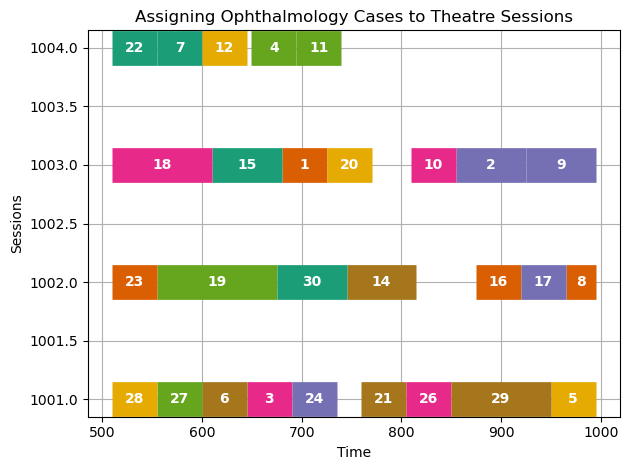

In [16]:
cbc_path = "C:\\Program Files\\Cbc-releases.2.10.8-w64-msvc16-md\\bin\\cbc.exe"
scheduler.solve(solver_name="cbc", solver_path=cbc_path, options=options)

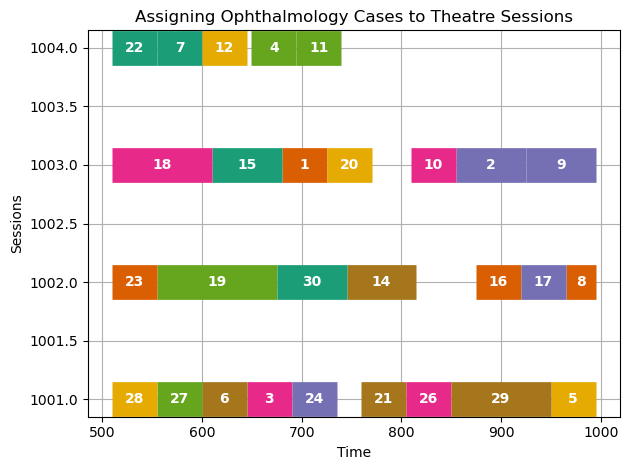

In [17]:
scheduler.draw_gantt()